In [1]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
import pandas as pd
import numpy as np
import string
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, Dataset
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import gc

In [2]:
train = pd.read_pickle('Preprocessing_Train.pkl')
X_train, X_test, y_train, y_test = train_test_split(train.document_text, train.label, test_size=0.25)

stop_words = stopwords.words('english')
non_neg_stop = [i for i in stop_words if "n't" not in i and "no" not in i]
lemma = WordNetLemmatizer()


def pos(x):
    if x.startswith('J'):
        return 'a'
    elif x.startswith('V'):
        return 'v'
    elif x.startswith('R'):
        return 'r'
    else:
        return 'n'
    
    
def tok(doc, non_neg=False, lemmatized=False):
    
    if non_neg:
        stop = non_neg_stop
    else:
        stop = stop_words
       
    tokens = re.split(r'\s', doc.lower())
    
    if lemmatized:
        pos_list = nltk.pos_tag(tokens)
        tokens = list(map(lambda x: lemma.lemmatize(x[0], pos(x[1])), pos_list))    

    tokens = [i for i in tokens if i not in stop]
    tokens = [i for i in tokens if len(re.findall(r'\w', i)) >= 2]
    tokens = [re.findall(r"\w[a-zA-Z0-9.-]*\w", i)[0] for i in tokens if re.findall(r"\w[a-zA-Z0-9.-]*\w", i)]
    
    return tokens


def get_voc_new(X, non_neg=True, lemmatized=True):
    
    voc = []
    token_list = []
    for i in X:
        tokens = tok(i, non_neg, lemmatized)
        token_list.append(tokens)
        voc += tokens
        
    voc = list(set(voc))
    
    return voc, token_list

In [3]:
voc, tk_list_train = get_voc_new(X_train, False, True)
# voc, tk_list_train = get_voc_new(train.document_text, False, True)
voc_test, tk_list_test = get_voc_new(X_test, False, True)
voc_dic = {item: idx+1 for idx, item in enumerate(voc)}

In [4]:
def word2idx(token_list):
    
    token_idx = []
    for sent in token_list:
        sent_list = []
        for token in sent:
            if token in voc_dic:
                idx = voc_dic[token]
            else:
                idx = 0
            sent_list.append(idx)
        token_idx.append(sent_list)

    return token_idx


tk_idx_train = word2idx(tk_list_train)
tk_idx_test = word2idx(tk_list_test)

In [5]:
class dataset_(Dataset):
    
    def __init__(self, X, y, max_len=1024):
        super(dataset_, self).__init__()
        pad = [i[:max_len] + [0]*(max_len-len(i[:max_len])) for i in X]
        self.X = torch.tensor(pad, dtype=torch.int32)
        self.y = torch.Tensor(np.array(list(y))[:, [8, 9, 22, 35]])
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
    
train_ = dataset_(tk_idx_train, y_train)
# train_ = dataset_(tk_idx_train, train.label)
test_ = dataset_(tk_idx_test, y_test)

In [7]:
class Emb(nn.Module):
    
    def __init__(self, voc_size, dim_emb):
        super(Emb, self).__init__()
        self.emb = nn.Sequential(
            nn.Embedding(voc_size, dim_emb, padding_idx=0),
            nn.Linear(dim_emb, 256),
            nn.ReLU())

    def forward(self, x):
        return self.emb(x)

    
class Conv1(nn.Module):
    
    def __init__(self, dim_emb, dim_out):
        super(Conv1, self).__init__()
        self.cv1 = nn.Sequential(
            nn.Conv1d(dim_emb, dim_out, 1),
            nn.BatchNorm1d(dim_out),
            nn.ReLU(),
            nn.MaxPool1d(3, 2))
        self.cv2 = nn.Sequential(
            nn.Conv1d(dim_emb, dim_out, 2),
            nn.BatchNorm1d(dim_out),
            nn.ReLU(),
            nn.MaxPool1d(3, 2)) 
        self.cv3 = nn.Sequential(
            nn.Conv1d(dim_emb, dim_out, 3),
            nn.BatchNorm1d(dim_out),
            nn.ReLU(),
            nn.MaxPool1d(2, 2))

    def forward(self, x):
        C1 = self.cv1(x.transpose(-2, -1)).transpose(-2, -1)
        C2 = self.cv2(x.transpose(-2, -1)).transpose(-2, -1)
        C3 = self.cv3(x.transpose(-2, -1)).transpose(-2, -1)
        return torch.cat([C1,C2,C3], dim=-1)
    
class Conv2(nn.Module):
    
    def __init__(self, dim_emb, dim_out):
        super(Conv2, self).__init__()
        self.cv1 = nn.Sequential(
            nn.Conv1d(dim_emb, dim_out, 1),
            nn.BatchNorm1d(dim_out),
            nn.ReLU(),
            nn.MaxPool1d(4, 2))
        self.cv2 = nn.Sequential(
            nn.Conv1d(dim_emb, dim_out, 2),
            nn.BatchNorm1d(dim_out),
            nn.ReLU(),
            nn.MaxPool1d(3, 2)) 
        self.cv3 = nn.Sequential(
            nn.Conv1d(dim_emb, dim_out, 3),
            nn.BatchNorm1d(dim_out),
            nn.ReLU(),
            nn.MaxPool1d(2, 2))

    def forward(self, x):
        C1 = self.cv1(x.transpose(-2, -1)).transpose(-2, -1)
        C2 = self.cv2(x.transpose(-2, -1)).transpose(-2, -1)
        C3 = self.cv3(x.transpose(-2, -1)).transpose(-2, -1)
        return torch.cat([C1,C2,C3], dim=-1)
    
    
class EndConv(nn.Module):
    
    def __init__(self, dim_emb, dim_out, conv_size):
        super(EndConv, self).__init__()
        self.ecv = nn.Sequential(
            nn.Conv1d(dim_emb, dim_out, conv_size),
            nn.BatchNorm1d(dim_out),
            nn.ReLU())

    def forward(self, x):
        Z = self.ecv(x.transpose(-2, -1))
        return nn.MaxPool1d(Z.size(-1))(Z).squeeze(-1)
    
            
class Att(nn.Module):
    
    def __init__(self, dim_emb=256, dim_enc=128):
        super(Att, self).__init__()
        self.Wq = nn.Linear(dim_emb, dim_enc, bias=False)
        self.Wk = nn.Linear(dim_emb, dim_emb, bias=False)
        self.Wv = nn.Linear(dim_emb, dim_emb, bias=False)

    def forward(self, x):
        K = self.Wk(x)
        V = self.Wv(x)
        temp = self.Wq(K) 
        score = temp.transpose(-2, -1) / math.sqrt(K.size(-1)) ## (50, 1200)
        return torch.matmul(nn.Softmax(dim=-1)(score), V)
    
    
class LN(nn.Module):
    
    def __init__(self, dim_emb=256):
        super(LN, self).__init__()
        self.feed = nn.LayerNorm(dim_emb)

    def forward(self, x):
        return x + self.feed(x)


class final_model(nn.Module):
    
    def __init__(self, voc_size=len(voc)+1, dim_emb=256, dropout=0.5, max_len=1024):
        super(final_model, self).__init__()
        self.net = nn.Sequential(
            Emb(voc_size, dim_emb),  ## (1024, dim_emb)
            Conv1(dim_emb, 128),
            Conv2(384, 128),
            EndConv(384, 256, 2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
            nn.Sigmoid())
            
    def forward(self, x):
        return self.net(x)

In [8]:
def train_model(model, train_dataset, eval_dataset, device, norm=0.5,
                lr=0.0005, epochs=50, batch_size=256):
    
    history = {'train_loss': [], 'eval_loss': [], 'detail_train': [], 'detail_eval': []}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

    model = model.to(device)
    save_loss = nn.BCELoss(reduction='none').to(device)
    
    if norm:
        Loss = nn.BCELoss(weight=train_.y.sum(axis=0)**-norm).to(device)

    else:
        Loss = nn.BCELoss().to(device)
        
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        eval_loss = 0
        detail_train = torch.zeros(4).to(device)
        detail_eval = torch.zeros(4).to(device)
        pred = []
        real = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X).squeeze(-1)
            loss = Loss(out, y)
            save_train = save_loss(out, y).sum(0)
            
            op.zero_grad()
            loss.backward()
            op.step()
            
            train_loss += loss
            detail_train += save_train
            
        model.eval()
        with torch.no_grad():
            for X, y in eval_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X).squeeze(-1)
                loss = Loss(out, y)
                save_eval = save_loss(out, y).sum(0)
                detail_eval += save_eval
                eval_loss += loss
                pred.append(out.cpu())
                real.append(y.cpu())
                
        train_loss = (train_loss/len(train_loader)).item()
        eval_loss = (eval_loss/len(eval_loader)).item() 
        
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)  
        history['detail_train'].append(detail_train.cpu().detach())
        history['detail_eval'].append(detail_eval.cpu().detach())  
        
        if not (epoch+1)%10:
            print(f"epoch {epoch+1}\ntrain loss: {train_loss}\t\teval loss: {eval_loss}")
        
        if not (epoch+1)%50:
            res = torch.cat(pred)
            tru = torch.cat(real)
            print(f'\nepoch {epoch+1}:\n')
            print(f"f1_score for 50 classes: {f1_score(tru, np.round(res), average='macro')}")
            print(classification_report(tru, np.round(res), target_names=['8','9','22','35']))
            print(f'\nSpent time: {time.time()-start} seconds')
            
        
    print('Training complete!')
    
    return history

Training start!
epoch 10
train loss: 0.002139141783118248		eval loss: 0.2321709245443344
epoch 20
train loss: 0.00026716693537309766		eval loss: 0.2790972888469696
epoch 30
train loss: 8.878252265276387e-05		eval loss: 0.2834634482860565
epoch 40
train loss: 4.307872222852893e-05		eval loss: 0.3233296871185303
epoch 50
train loss: 2.3913136828923598e-05		eval loss: 0.32576054334640503

epoch 50:

f1_score for 50 classes: 0.6105555098696266
              precision    recall  f1-score   support

           8       0.95      0.50      0.65       125
           9       0.82      0.52      0.64       231
          22       0.77      0.52      0.62       212
          35       0.86      0.38      0.53       189

   micro avg       0.83      0.48      0.61       757
   macro avg       0.85      0.48      0.61       757
weighted avg       0.84      0.48      0.61       757
 samples avg       0.13      0.13      0.13       757


Spent time: 399.89486289024353 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 60
train loss: 1.380993035127176e-05		eval loss: 0.3238995373249054
epoch 70
train loss: 7.95444520917954e-06		eval loss: 0.3498976230621338
epoch 80
train loss: 5.3508592827711254e-06		eval loss: 0.3587622046470642
epoch 90
train loss: 3.5486284559738124e-06		eval loss: 0.37055879831314087
epoch 100
train loss: 2.4737930743867764e-06		eval loss: 0.38188862800598145

epoch 100:

f1_score for 50 classes: 0.6121343251268334
              precision    recall  f1-score   support

           8       0.97      0.48      0.64       125
           9       0.75      0.57      0.65       231
          22       0.74      0.56      0.64       212
          35       0.86      0.38      0.52       189

   micro avg       0.79      0.50      0.62       757
   macro avg       0.83      0.50      0.61       757
weighted avg       0.81      0.50      0.61       757
 samples avg       0.14      0.14      0.14       757


Spent time: 789.3475403785706 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 110
train loss: 1.4447028888753266e-06		eval loss: 0.399326354265213
epoch 120
train loss: 1.0577239208942046e-06		eval loss: 0.42101117968559265
epoch 130
train loss: 6.938356023056258e-07		eval loss: 0.4313143789768219
epoch 140
train loss: 4.216847173665883e-07		eval loss: 0.4309840202331543
epoch 150
train loss: 2.9583020477730315e-07		eval loss: 0.4396032392978668

epoch 150:

f1_score for 50 classes: 0.6235351641847177
              precision    recall  f1-score   support

           8       0.96      0.52      0.67       125
           9       0.82      0.53      0.65       231
          22       0.77      0.53      0.63       212
          35       0.88      0.40      0.55       189

   micro avg       0.84      0.50      0.62       757
   macro avg       0.86      0.49      0.62       757
weighted avg       0.84      0.50      0.62       757
 samples avg       0.14      0.13      0.13       757


Spent time: 1173.1535396575928 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 160
train loss: 2.1699578667266906e-07		eval loss: 0.4503426253795624
epoch 170
train loss: 1.5159817223775462e-07		eval loss: 0.46451789140701294
epoch 180
train loss: 1.2361311974018463e-07		eval loss: 0.48479682207107544
epoch 190
train loss: 7.876391094896462e-08		eval loss: 0.49246081709861755
epoch 200
train loss: 4.9944894442432997e-08		eval loss: 0.5033848285675049

epoch 200:

f1_score for 50 classes: 0.621377927356515
              precision    recall  f1-score   support

           8       0.96      0.52      0.67       125
           9       0.83      0.53      0.65       231
          22       0.75      0.53      0.62       212
          35       0.88      0.39      0.54       189

   micro avg       0.83      0.49      0.62       757
   macro avg       0.86      0.49      0.62       757
weighted avg       0.84      0.49      0.62       757
 samples avg       0.14      0.13      0.13       757


Spent time: 1561.7246580123901 seconds
Training complete!


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


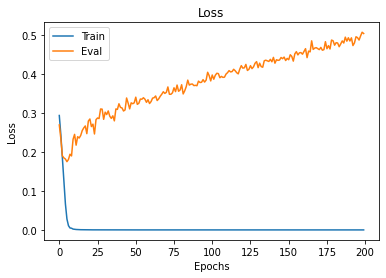

In [9]:
mod = final_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200
lr = 3e-4
batch_size = 128
norm = None

hist = train_model(mod, train_, test_, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss'], label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss'], label='Eval')
plt.legend();